## 合并3dpf和6dpf的基因表达矩阵，进行差异比较

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
cell_anno_3dpf = pd.read_csv("./F314-1230/output/vas_cell_matrix_annotation.csv")
cell_anno_3dpf.drop(["cor"], axis=1, inplace=True)
cell_anno_3dpf = cell_anno_3dpf[cell_anno_3dpf['cell_type'] != "other"]
col_name_3dpf = cell_anno_3dpf.columns.tolist()
col_name_3dpf[-3] = "zgc158423"
cell_anno_3dpf.columns = col_name_3dpf

cell_anno_6dpf = pd.read_csv("./F610-1119/output/vascular_cell_gene_annotation.csv", index_col=0)
cell_anno_6dpf.insert(0, "cell_id", cell_anno_6dpf["cell"])
cell_anno_6dpf.drop(["y", "x", "blood", "cor", "cell", "row_sum","eGFP", "kdrl", "pecam1"], axis=1, inplace=True)
cell_anno_6dpf = cell_anno_6dpf[cell_anno_6dpf['cell_type'] != "other"]

cell_anno_3dpf.columns.tolist() == cell_anno_6dpf.columns.tolist()
cell_anno_3dpf.to_csv("./output_int/cell_anno_3dpf.csv", index=False)
cell_anno_6dpf.to_csv("./output_int/cell_anno_6dpf.csv", index=False)

In [ ]:
cell_anno_3dpf = pd.read_csv("./F314-1230/output/vas_cell_matrix_annotation.csv")
cell_anno_3dpf = cell_anno_3dpf[cell_anno_3dpf['cell_type'] != "other"]
c2b = pd.read_csv("./F314-1230/emailfiles/11.20250414/cell2blood.csv")
c2b = c2b[c2b.cell.isin(cell_anno_3dpf.cell_id)]
c2b.columns = ["cell_x", "cell_y", "cell_id", "region_id"]
m = pd.merge(cell_anno_3dpf, c2b, on="cell_id")
m.drop(["cor"], axis=1, inplace=True)
m.head()
m.to_csv("./cell_ann_3dpf_with_regionid.csv", index=False)

In [ ]:
cell_anno_6dpf = pd.read_csv("./F610-1119/output/vascular_cell_gene_annotation.csv", index_col=0)
cell_anno_6dpf.insert(0, "cell_id", cell_anno_6dpf["cell"])
cell_anno_6dpf.drop(["cor", "cell", "row_sum"], axis=1, inplace=True)
cell_anno_6dpf = cell_anno_6dpf[cell_anno_6dpf['cell_type'] != "other"]
colname = cell_anno_6dpf.columns.tolist()
colname[-4:] = ["cell_type","x", "y", "blood"]
cell_anno_6dpf = cell_anno_6dpf.loc[:, colname]
colname = cell_anno_6dpf.columns.tolist()
colname[-3:] = ["cell_x", "cell_y", "region_id"]
cell_anno_6dpf.columns = colname
cell_anno_6dpf.to_csv("./cell_anno_6dpf_with_regionid.csv", index=False)

## 按血管类型统计基因的表达变化

In [1]:
import pandas as pd
import numpy as np

#### 对于3dpf--基于血管名称

In [2]:
# 过滤vas_anno_3dpf
vas_anno_3dpf = pd.read_csv("./F314-1230/output/F314血管注释_all.csv")
vas_anno_3dpf = vas_anno_3dpf.loc[:,["region_id", "region_name_pri", 'feature_name']]
vas_anno_3dpf.columns = ["region_id", "region_name", "feature_name"]
vas_anno_3dpf.head()

,region_id,region_name,feature_name
0,blood_95,dorsal,cldn5a
1,blood_95,dorsal,cldn5a
2,blood_95,dorsal,eGFP
3,blood_95,dorsal,eGFP
4,blood_95,dorsal,eGFP


In [3]:
# 基于vas_anno_3dpf计算vas_matrix_3dpf
vas_matrix_3dpf = vas_anno_3dpf.groupby(["region_name"], as_index = False)["feature_name"].value_counts()
vas_matrix_3dpf = vas_matrix_3dpf[~vas_matrix_3dpf['region_name'].isin(['?','Trunk', 'bottom','no', 'other', "EYE"])]
vas_matrix_3dpf["region_name"] = [x.title() if x in ['dorsal', 'willis'] else x for x in vas_matrix_3dpf.region_name  ]
vas_matrix_3dpf.head()

,region_name,feature_name,count
1,AMsCtA,eGFP,357
2,AMsCtA,slc7a5,297
3,AMsCtA,zgc:158423,149
4,AMsCtA,slc16a1a,116
5,AMsCtA,slc2a1a,103


In [4]:
# 计算和统计vas_area_3dpf
vas_area_3dpf = pd.read_csv("./F314-1230/output/region_area_F314.csv")
vas_area_3dpf = vas_area_3dpf[vas_area_3dpf["region_id"].isin(vas_anno_3dpf["region_id"])]
vas_area_3dpf = pd.merge(vas_area_3dpf, vas_anno_3dpf, on="region_id")
vas_area_3dpf = vas_area_3dpf.loc[:,["region_id", "region_name", "region_area", "slice_region"]]
vas_area_3dpf = vas_area_3dpf.drop_duplicates(["region_id"])
vas_area_3dpf = vas_area_3dpf[~vas_area_3dpf['region_name'].isin(['?','Trunk', 'bottom','no', 'other', "EYE"])]
vas_area_3dpf = vas_area_3dpf.groupby(["region_name"], as_index = False)["region_area"].sum()
vas_area_3dpf["region_name"] = [x.title() if x in ['dorsal', 'willis'] else x for x in vas_area_3dpf.region_name  ]
vas_area_3dpf.head()

,region_name,region_area
0,AMsCtA,103474.5
1,BA,40018.5
2,CaDI,10314.5
3,CeCtA,72525.5
4,MMsCtA,135729.0


In [5]:
# 合并数据与vas_3dpf中
vas_3dpf = pd.merge(vas_matrix_3dpf, vas_area_3dpf, on="region_name")
# 计算count_norm
vas_3dpf.loc[:,"count_norm"] = (vas_3dpf["count"] * 1000 / vas_3dpf["region_area"]).round(3)
# 添加分组信息
vas_3dpf.loc[:,'group'] = "3dpf"
vas_3dpf.head()

,region_name,feature_name,count,region_area,count_norm,group
0,AMsCtA,eGFP,357,103474.5,3.450,3dpf
1,AMsCtA,slc7a5,297,103474.5,2.870,3dpf
2,AMsCtA,zgc:158423,149,103474.5,1.440,3dpf
3,AMsCtA,slc16a1a,116,103474.5,1.121,3dpf
4,AMsCtA,slc2a1a,103,103474.5,0.995,3dpf


#### 对于6dpf--基于血管名称


In [6]:
vas_anno_6dpf = pd.read_csv("./F610-1119/output/F610血管注释_all.csv")
vas_anno_6dpf = vas_anno_6dpf.loc[:,["region_id", "regionName", 'feature_name']]
vas_anno_6dpf.columns = ["region_id", "region_name", "feature_name"]
vas_anno_6dpf.head()


,region_id,region_name,feature_name
0,region7,MoCtA,agtr1b
1,region7,MoCtA,eGFP
2,region7,MoCtA,prdx1
3,region7,MoCtA,zgc158423
4,region7,MoCtA,lypd6


In [7]:
# 基于vas_anno_6dpf计算vas_matrix_6dpf
vas_matrix_6dpf = vas_anno_6dpf.groupby(["region_name"], as_index = False)["feature_name"].value_counts()
vas_matrix_6dpf = vas_matrix_6dpf[~vas_matrix_6dpf['region_name'].isin(['?','Trunk', 'bottom','no', 'other', "EYE"])]
vas_matrix_6dpf["region_name"] = [x.title() if x in ['dorsal', 'willis'] else x for x in vas_matrix_6dpf.region_name  ]
print(vas_matrix_6dpf.shape)
vas_matrix_6dpf.head()

(647, 3)


,region_name,feature_name,count
0,AMsCtA,eGFP,268
1,AMsCtA,slc7a5,132
2,AMsCtA,cldn5a,67
3,AMsCtA,zgc158423,50
4,AMsCtA,bcl6b,48


In [8]:
# 计算和统计vas_area_6dpf
vas_area_6dpf = pd.read_csv("./F610-1119/output/region_area_F610.csv")
vas_area_6dpf = vas_area_6dpf[vas_area_6dpf["region_id"].isin(vas_anno_6dpf["region_id"])]
vas_area_6dpf = pd.merge(vas_area_6dpf, vas_anno_6dpf, on="region_id")
vas_area_6dpf = vas_area_6dpf.loc[:,["region_id", "region_name", "region_area", "slice_region"]]
vas_area_6dpf = vas_area_6dpf.drop_duplicates(["region_id"])
vas_area_6dpf = vas_area_6dpf[~vas_area_6dpf['region_name'].isin(['?','Trunk', 'bottom','no', 'other', "EYE"])]
vas_area_6dpf = vas_area_6dpf.groupby(["region_name"], as_index = False)["region_area"].sum()
vas_area_6dpf.head()

,region_name,region_area
0,AMsCtA,69137.0
1,BA,48568.5
2,CaDI,2340.5
3,CeCtA,42955.0
4,Dorsal,19893.0


In [9]:
# 合并数据与vas_6dpf中
vas_6dpf = pd.merge(vas_matrix_6dpf, vas_area_6dpf, on="region_name")
# 计算count_norm
vas_6dpf.loc[:,"count_norm"] = (vas_6dpf["count"] * 1000 / vas_6dpf["region_area"]).round(3)
# 添加分组信息
vas_6dpf.loc[:,'group'] = "6dpf"
vas_6dpf.head()

,region_name,feature_name,count,region_area,count_norm,group
0,AMsCtA,eGFP,268,69137.0,3.876,6dpf
1,AMsCtA,slc7a5,132,69137.0,1.909,6dpf
2,AMsCtA,cldn5a,67,69137.0,0.969,6dpf
3,AMsCtA,zgc158423,50,69137.0,0.723,6dpf
4,AMsCtA,bcl6b,48,69137.0,0.694,6dpf


#### 对于11dpf-基于血管名称

In [43]:
vas_anno_11dpf = pd.read_csv("./F1109-0312/output/F1109血管注释_all.csv")
vas_anno_11dpf = vas_anno_11dpf.loc[:,["region_id", "region_name_pri", 'feature_name']]
vas_anno_11dpf.columns = ["region_id", "region_name", "feature_name"]
vas_anno_11dpf.dropna(subset=["region_name"], inplace=True)
vas_anno_11dpf["region_name"] = ["Willis" if x == "Wiliis" else x for x in vas_anno_11dpf.region_name]
vas_anno_11dpf.head()

,region_id,region_name,feature_name
0,blood_419,PMsCtA,pdgfrb
1,blood_419,PMsCtA,pdgfrb
2,blood_419,PMsCtA,eGFP
3,blood_419,PMsCtA,eGFP
4,blood_419,PMsCtA,eGFP


In [61]:
vas_anno_11dpf

,region_id,region_name,feature_name
0,blood_419,PMsCtA,pdgfrb
1,blood_419,PMsCtA,pdgfrb
2,blood_419,PMsCtA,eGFP
3,blood_419,PMsCtA,eGFP
4,blood_419,PMsCtA,eGFP
...,...,...,...
21072,blood_3455,AMsCtA,abcb4
21073,blood_3455,AMsCtA,abcb4
21074,blood_3455,AMsCtA,myo1hb
21075,blood_3455,AMsCtA,zic2b


In [44]:
# 基于vas_anno_11dpf计算vas_matrix_11dpf
vas_matrix_11dpf = vas_anno_11dpf.groupby(["region_name"], as_index = False)["feature_name"].value_counts()
vas_matrix_11dpf = vas_matrix_11dpf[~vas_matrix_11dpf['region_name'].isin(['?','Trunk', 'bottom','no', 'other', "EYE"])]
vas_matrix_11dpf["region_name"] = [x.title() if x in ['dorsal', 'willis'] else x for x in vas_matrix_11dpf.region_name  ]
print(vas_matrix_11dpf.shape)
vas_matrix_11dpf.head()

(537, 3)


,region_name,feature_name,count
0,AMsCtA,eGFP,294
1,AMsCtA,slc7a5,247
2,AMsCtA,zgc:158423,97
3,AMsCtA,cldn5a,95
4,AMsCtA,slco1c1,93


In [45]:
# 计算和统计vas_area_11dpf
vas_area_11dpf = pd.read_csv("./F1109-0312/output/region_area_F1109.csv")
vas_area_11dpf = vas_area_11dpf[vas_area_11dpf["region_id"].isin(vas_anno_11dpf["region_id"])]
vas_area_11dpf = pd.merge(vas_area_11dpf, vas_anno_11dpf, on="region_id")
vas_area_11dpf = vas_area_11dpf.loc[:,["region_id", "region_name", "region_area", "slice_region"]]
vas_area_11dpf = vas_area_11dpf.drop_duplicates(["region_id"])
vas_area_11dpf = vas_area_11dpf[~vas_area_11dpf['region_name'].isin(['?','Trunk', 'bottom','no', 'other', "EYE"])]
vas_area_11dpf = vas_area_11dpf.groupby(["region_name"], as_index = False)["region_area"].sum()
vas_area_11dpf.head()

,region_name,region_area
0,AMsCtA,102512.0
1,BA,39892.5
2,CaDI,7717.5
3,CeCtA,25349.0
4,Dorsal,76485.0


In [46]:
# 合并数据与vas_6dpf中
vas_11dpf = pd.merge(vas_matrix_11dpf, vas_area_11dpf, on="region_name")
# 计算count_norm
vas_11dpf.loc[:,"count_norm"] = (vas_11dpf["count"] * 1000 / vas_11dpf["region_area"]).round(3)
# 添加分组信息
vas_11dpf.loc[:,'group'] = "11dpf"
vas_11dpf.head()

,region_name,feature_name,count,region_area,count_norm,group
0,AMsCtA,eGFP,294,102512.0,2.868,11dpf
1,AMsCtA,slc7a5,247,102512.0,2.409,11dpf
2,AMsCtA,zgc:158423,97,102512.0,0.946,11dpf
3,AMsCtA,cldn5a,95,102512.0,0.927,11dpf
4,AMsCtA,slco1c1,93,102512.0,0.907,11dpf


In [47]:
# 合并3dpf、6dpf和11dpf的数据
vas_matrix = pd.concat([vas_3dpf, vas_6dpf, vas_11dpf], axis=0, ignore_index=True)
vas_matrix["feature_name"] = ["zgc:158423" if x == "zgc158423" else x for x in vas_matrix.feature_name]
vas_matrix.head()

,region_name,feature_name,count,region_area,count_norm,group
0,AMsCtA,eGFP,357,103474.5,3.450,3dpf
1,AMsCtA,slc7a5,297,103474.5,2.870,3dpf
2,AMsCtA,zgc:158423,149,103474.5,1.440,3dpf
3,AMsCtA,slc16a1a,116,103474.5,1.121,3dpf
4,AMsCtA,slc2a1a,103,103474.5,0.995,3dpf


In [48]:
vas_matrix = vas_matrix.sort_values(by=["region_name", "feature_name"])
vas_matrix

,region_name,feature_name,count,region_area,count_norm,group
16,AMsCtA,abcb4,36,103474.5,0.348,3dpf
608,AMsCtA,abcb4,27,69137.0,0.391,6dpf
1250,AMsCtA,abcb4,90,102512.0,0.878,11dpf
30,AMsCtA,abcc2,20,103474.5,0.193,3dpf
627,AMsCtA,abcc2,9,69137.0,0.130,6dpf
...,...,...,...,...,...,...
1209,Willis,zgc:158423,47,22410.0,2.097,6dpf
1747,Willis,zgc:158423,31,36806.0,0.842,11dpf
579,Willis,zic2b,26,65709.0,0.396,3dpf
1235,Willis,zic2b,4,22410.0,0.178,6dpf


In [49]:
vas_local = pd.read_csv("./F314-1230/output/vascular_name.csv")
vas_local.columns = ["location", "region_name", "index"]
vas_local

,location,region_name,index
0,Ventral side,CaDI,1
1,Ventral side,Willis,2
2,Prosencephalic subnetwork,PrCm,3
3,Mesencephalic subnetwork,AMsCtA,4
4,Mesencephalic subnetwork,MMsCtA,5
5,Mesencephalic subnetwork,PMsCtA,6
6,Metenbcephalic subnetwork,MtA,7
7,Metenbcephalic subnetwork,CeCtA,8
8,Metenbcephalic subnetwork,MoCtA,9
9,Metenbcephalic subnetwork,BA,10


In [50]:
vas = pd.merge(vas_local, vas_matrix, on="region_name")

In [71]:
vas.to_csv("./output_int/vas_gene_expr_vastype.csv", index=False)

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

/home/xiaoyu_li/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


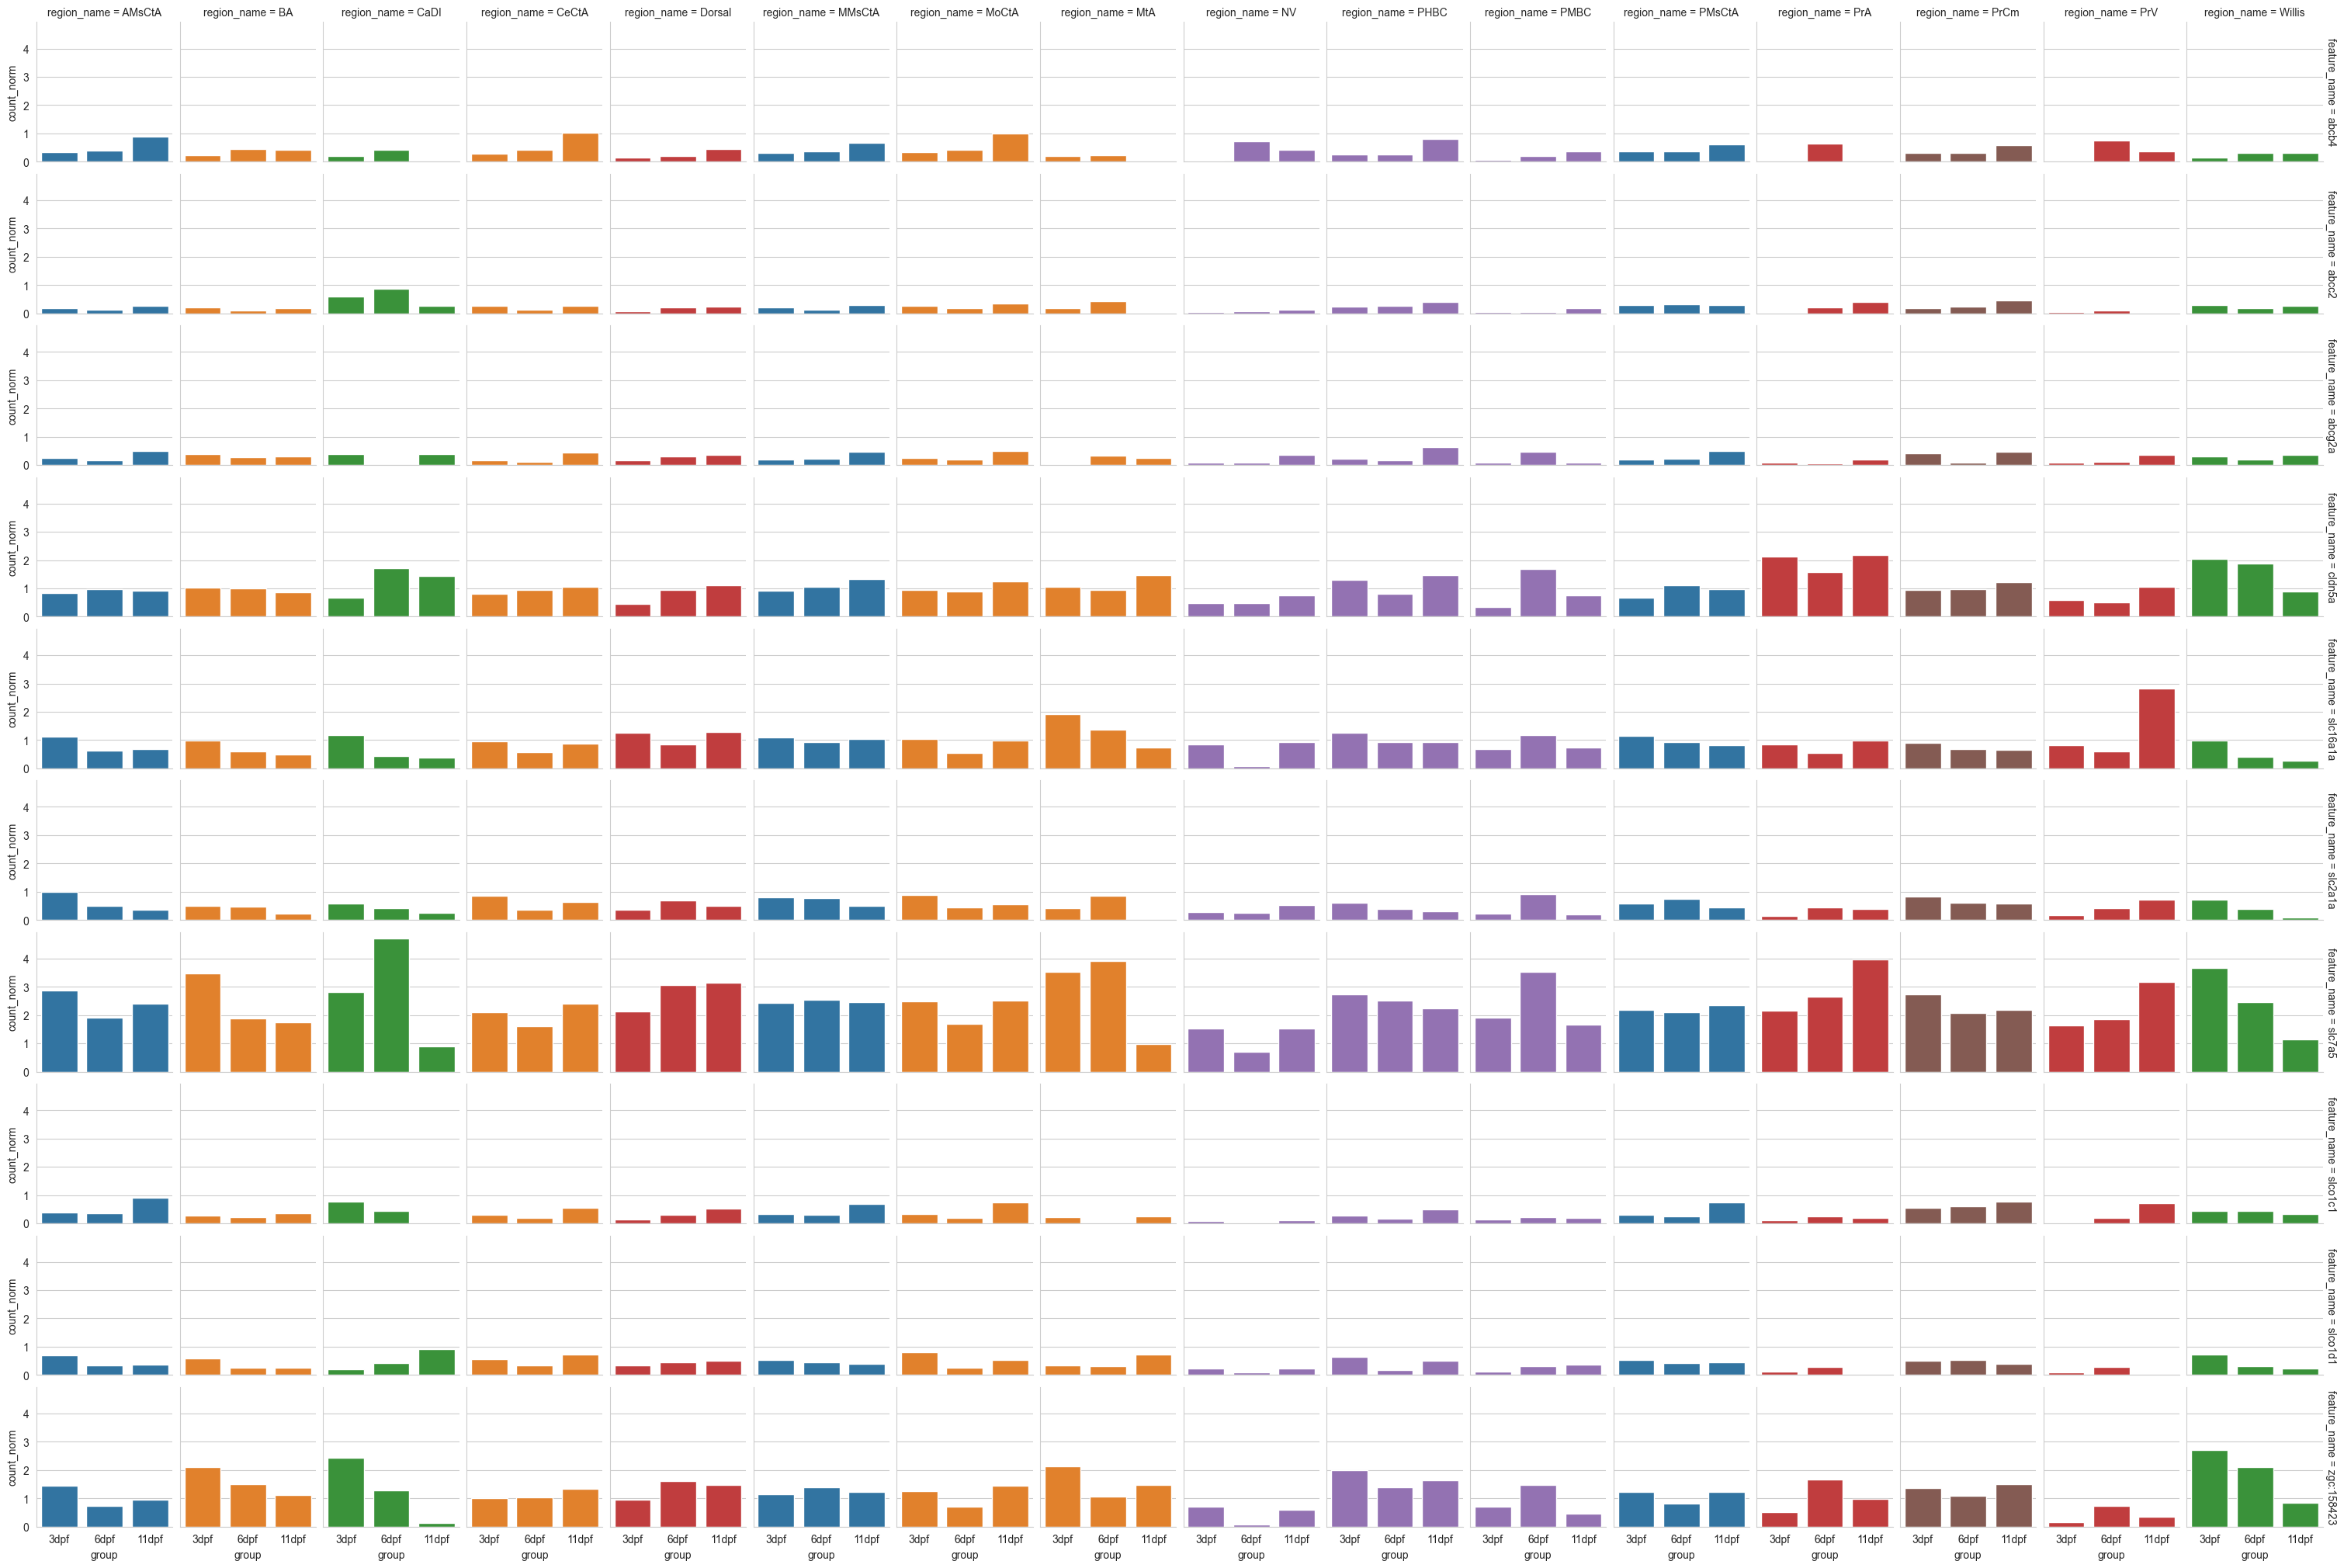

In [77]:
plot_data = vas[vas["feature_name"].isin(["slc16a1a", "zgc:158423", "slco1c1",'slc7a5',"slco1d1" ,"abcb4", "abcg2a", "abcc2",'slc2a1a',"cldn5a"])]
plot_data = plot_data.sort_values(by=["region_name", "feature_name"])
g = sns.FacetGrid(data=plot_data,row= "feature_name", col="region_name", margin_titles=True, hue = "location", sharey=False, sharex = False)
ax=g.map(sns.barplot, "group", "count_norm")
plt.tight_layout()
ax.figure.set_size_inches(30,20)

#### 对于3dpf--基于血管位置（前中后脑，背腹侧以及两侧）

In [23]:
vas_area_3dpf_2 = pd.read_csv("./F314-1230/output/region_area_F314.csv")
vas_area_3dpf_2 = vas_area_3dpf_2[vas_area_3dpf_2["region_id"].isin(vas_anno_3dpf["region_id"])]
vas_area_3dpf_2 = pd.merge(vas_area_3dpf_2, vas_anno_3dpf, on="region_id")
vas_area_3dpf_2 = pd.merge(vas_area_3dpf_2, vas_local, on="region_name")
vas_area_3dpf_2 = vas_area_3dpf_2.loc[:,["region_id", "location", "region_area"]]
vas_area_3dpf_2 = vas_area_3dpf_2.drop_duplicates(["region_id"])
vas_area_3dpf_2 = vas_area_3dpf_2.groupby(["location"], as_index = False)["region_area"].sum()
vas_local_3dpf = pd.merge(vas_local, vas_anno_3dpf, on="region_name")
vas_local_3dpf = vas_local_3dpf.groupby(["location"], as_index = False)["feature_name"].value_counts()
vas_local_3dpf = pd.merge(vas_local_3dpf, vas_area_3dpf_2, on="location")
vas_local_3dpf.loc[:,"count_norm"] = (vas_local_3dpf["count"] * 10000 / vas_local_3dpf["region_area"]).round(3)
vas_local_3dpf.loc[:,"group"] = "3dpf"
vas_local_3dpf.head()

,location,feature_name,count,region_area,count_norm,group
0,Bilateral vascular,slc7a5,1262,584755.5,21.582,3dpf
1,Bilateral vascular,eGFP,1096,584755.5,18.743,3dpf
2,Bilateral vascular,zgc:158423,686,584755.5,11.731,3dpf
3,Bilateral vascular,slc16a1a,530,584755.5,9.064,3dpf
4,Bilateral vascular,bcl6b,428,584755.5,7.319,3dpf


#### 对于6dpf--基于血管位置（前中后脑，背腹侧以及两侧）

In [24]:
vas_area_6dpf_2 = pd.read_csv("./F610-1119/output/region_area_F610.csv")
vas_area_6dpf_2 = vas_area_6dpf_2[vas_area_6dpf_2["region_id"].isin(vas_anno_6dpf["region_id"])]
vas_area_6dpf_2 = pd.merge(vas_area_6dpf_2, vas_anno_6dpf, on="region_id")
vas_area_6dpf_2 = pd.merge(vas_area_6dpf_2, vas_local, on="region_name")
vas_area_6dpf_2 = vas_area_6dpf_2.loc[:,["region_id", "location", "region_area"]]
vas_area_6dpf_2 = vas_area_6dpf_2.drop_duplicates(["region_id"])
vas_area_6dpf_2 = vas_area_6dpf_2.groupby(["location"], as_index = False)["region_area"].sum()
vas_local_6dpf = pd.merge(vas_local, vas_anno_6dpf, on="region_name")
vas_local_6dpf = vas_local_6dpf.groupby(["location"], as_index = False)["feature_name"].value_counts()
vas_local_6dpf = pd.merge(vas_local_6dpf, vas_area_6dpf_2, on="location")
vas_local_6dpf.loc[:,"count_norm"] = (vas_local_6dpf["count"] * 10000 / vas_local_6dpf["region_area"]).round(3)
vas_local_6dpf.loc[:,"group"] = "6dpf"
vas_local_6dpf.head()

,location,feature_name,count,region_area,count_norm,group
0,Bilateral vascular,eGFP,410,89323.5,45.901,6dpf
1,Bilateral vascular,slc7a5,222,89323.5,24.853,6dpf
2,Bilateral vascular,zgc158423,110,89323.5,12.315,6dpf
3,Bilateral vascular,aoc2,85,89323.5,9.516,6dpf
4,Bilateral vascular,cldn5a,85,89323.5,9.516,6dpf


In [64]:
vas_area_11dpf_2 = pd.read_csv("./F1109-0312/output/region_area_F1109.csv")
vas_area_11dpf_2 = vas_area_11dpf_2[vas_area_11dpf_2["region_id"].isin(vas_anno_11dpf["region_id"])]
vas_area_11dpf_2 = pd.merge(vas_area_11dpf_2, vas_anno_11dpf, on="region_id")
vas_area_11dpf_2 = pd.merge(vas_area_11dpf_2, vas_local, on="region_name")
vas_area_11dpf_2 = vas_area_11dpf_2.loc[:,["region_id", "location", "region_area"]]
vas_area_11dpf_2 = vas_area_11dpf_2.drop_duplicates(["region_id"])
vas_area_11dpf_2 = vas_area_11dpf_2.groupby(["location"], as_index = False)["region_area"].sum()
vas_local_11dpf = pd.merge(vas_local, vas_anno_11dpf, on="region_name")
vas_local_11dpf = vas_local_11dpf.groupby(["location"], as_index = False)["feature_name"].value_counts()
vas_local_11dpf = pd.merge(vas_local_11dpf, vas_area_11dpf_2, on="location")
vas_local_11dpf.loc[:,"count_norm"] = (vas_local_11dpf["count"] * 10000 / vas_local_11dpf["region_area"]).round(3)
vas_local_11dpf.loc[:,"group"] = "11dpf"
vas_local_11dpf.head()

,location,feature_name,count,region_area,count_norm,group
0,Bilateral vascular,eGFP,658,140608.0,46.797,11dpf
1,Bilateral vascular,slc7a5,297,140608.0,21.123,11dpf
2,Bilateral vascular,zgc:158423,200,140608.0,14.224,11dpf
3,Bilateral vascular,cldn5a,185,140608.0,13.157,11dpf
4,Bilateral vascular,slc16a1a,129,140608.0,9.174,11dpf


In [65]:
vas_local_11dpf.location.unique()

array(['Bilateral vascular', 'Dorsal side', 'Mesencephalic subnetwork',
       'Metenbcephalic subnetwork', 'Prosencephalic subnetwork',
       'Ventral side'], dtype=object)

In [66]:
vas_2 = pd.concat([vas_local_3dpf, vas_local_6dpf, vas_local_11dpf], axis=0, ignore_index=True)
vas_2["feature_name"] = ["zgc:158423" if x == "zgc158423" else x for x in vas_2.feature_name]
vas_2.head()

,location,feature_name,count,region_area,count_norm,group
0,Bilateral vascular,slc7a5,1262,584755.5,21.582,3dpf
1,Bilateral vascular,eGFP,1096,584755.5,18.743,3dpf
2,Bilateral vascular,zgc:158423,686,584755.5,11.731,3dpf
3,Bilateral vascular,slc16a1a,530,584755.5,9.064,3dpf
4,Bilateral vascular,bcl6b,428,584755.5,7.319,3dpf


In [67]:
vas_2.to_csv("./output_int/vas_gene_expr_vasloc.csv", index=False)

In [68]:
vas_2.location.unique()

array(['Bilateral vascular', 'Dorsal side', 'Mesencephalic subnetwork',
       'Metenbcephalic subnetwork', 'Prosencephalic subnetwork',
       'Ventral side'], dtype=object)

In [69]:
import seaborn as sns

/home/xiaoyu_li/miniconda3/envs/pytorch/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


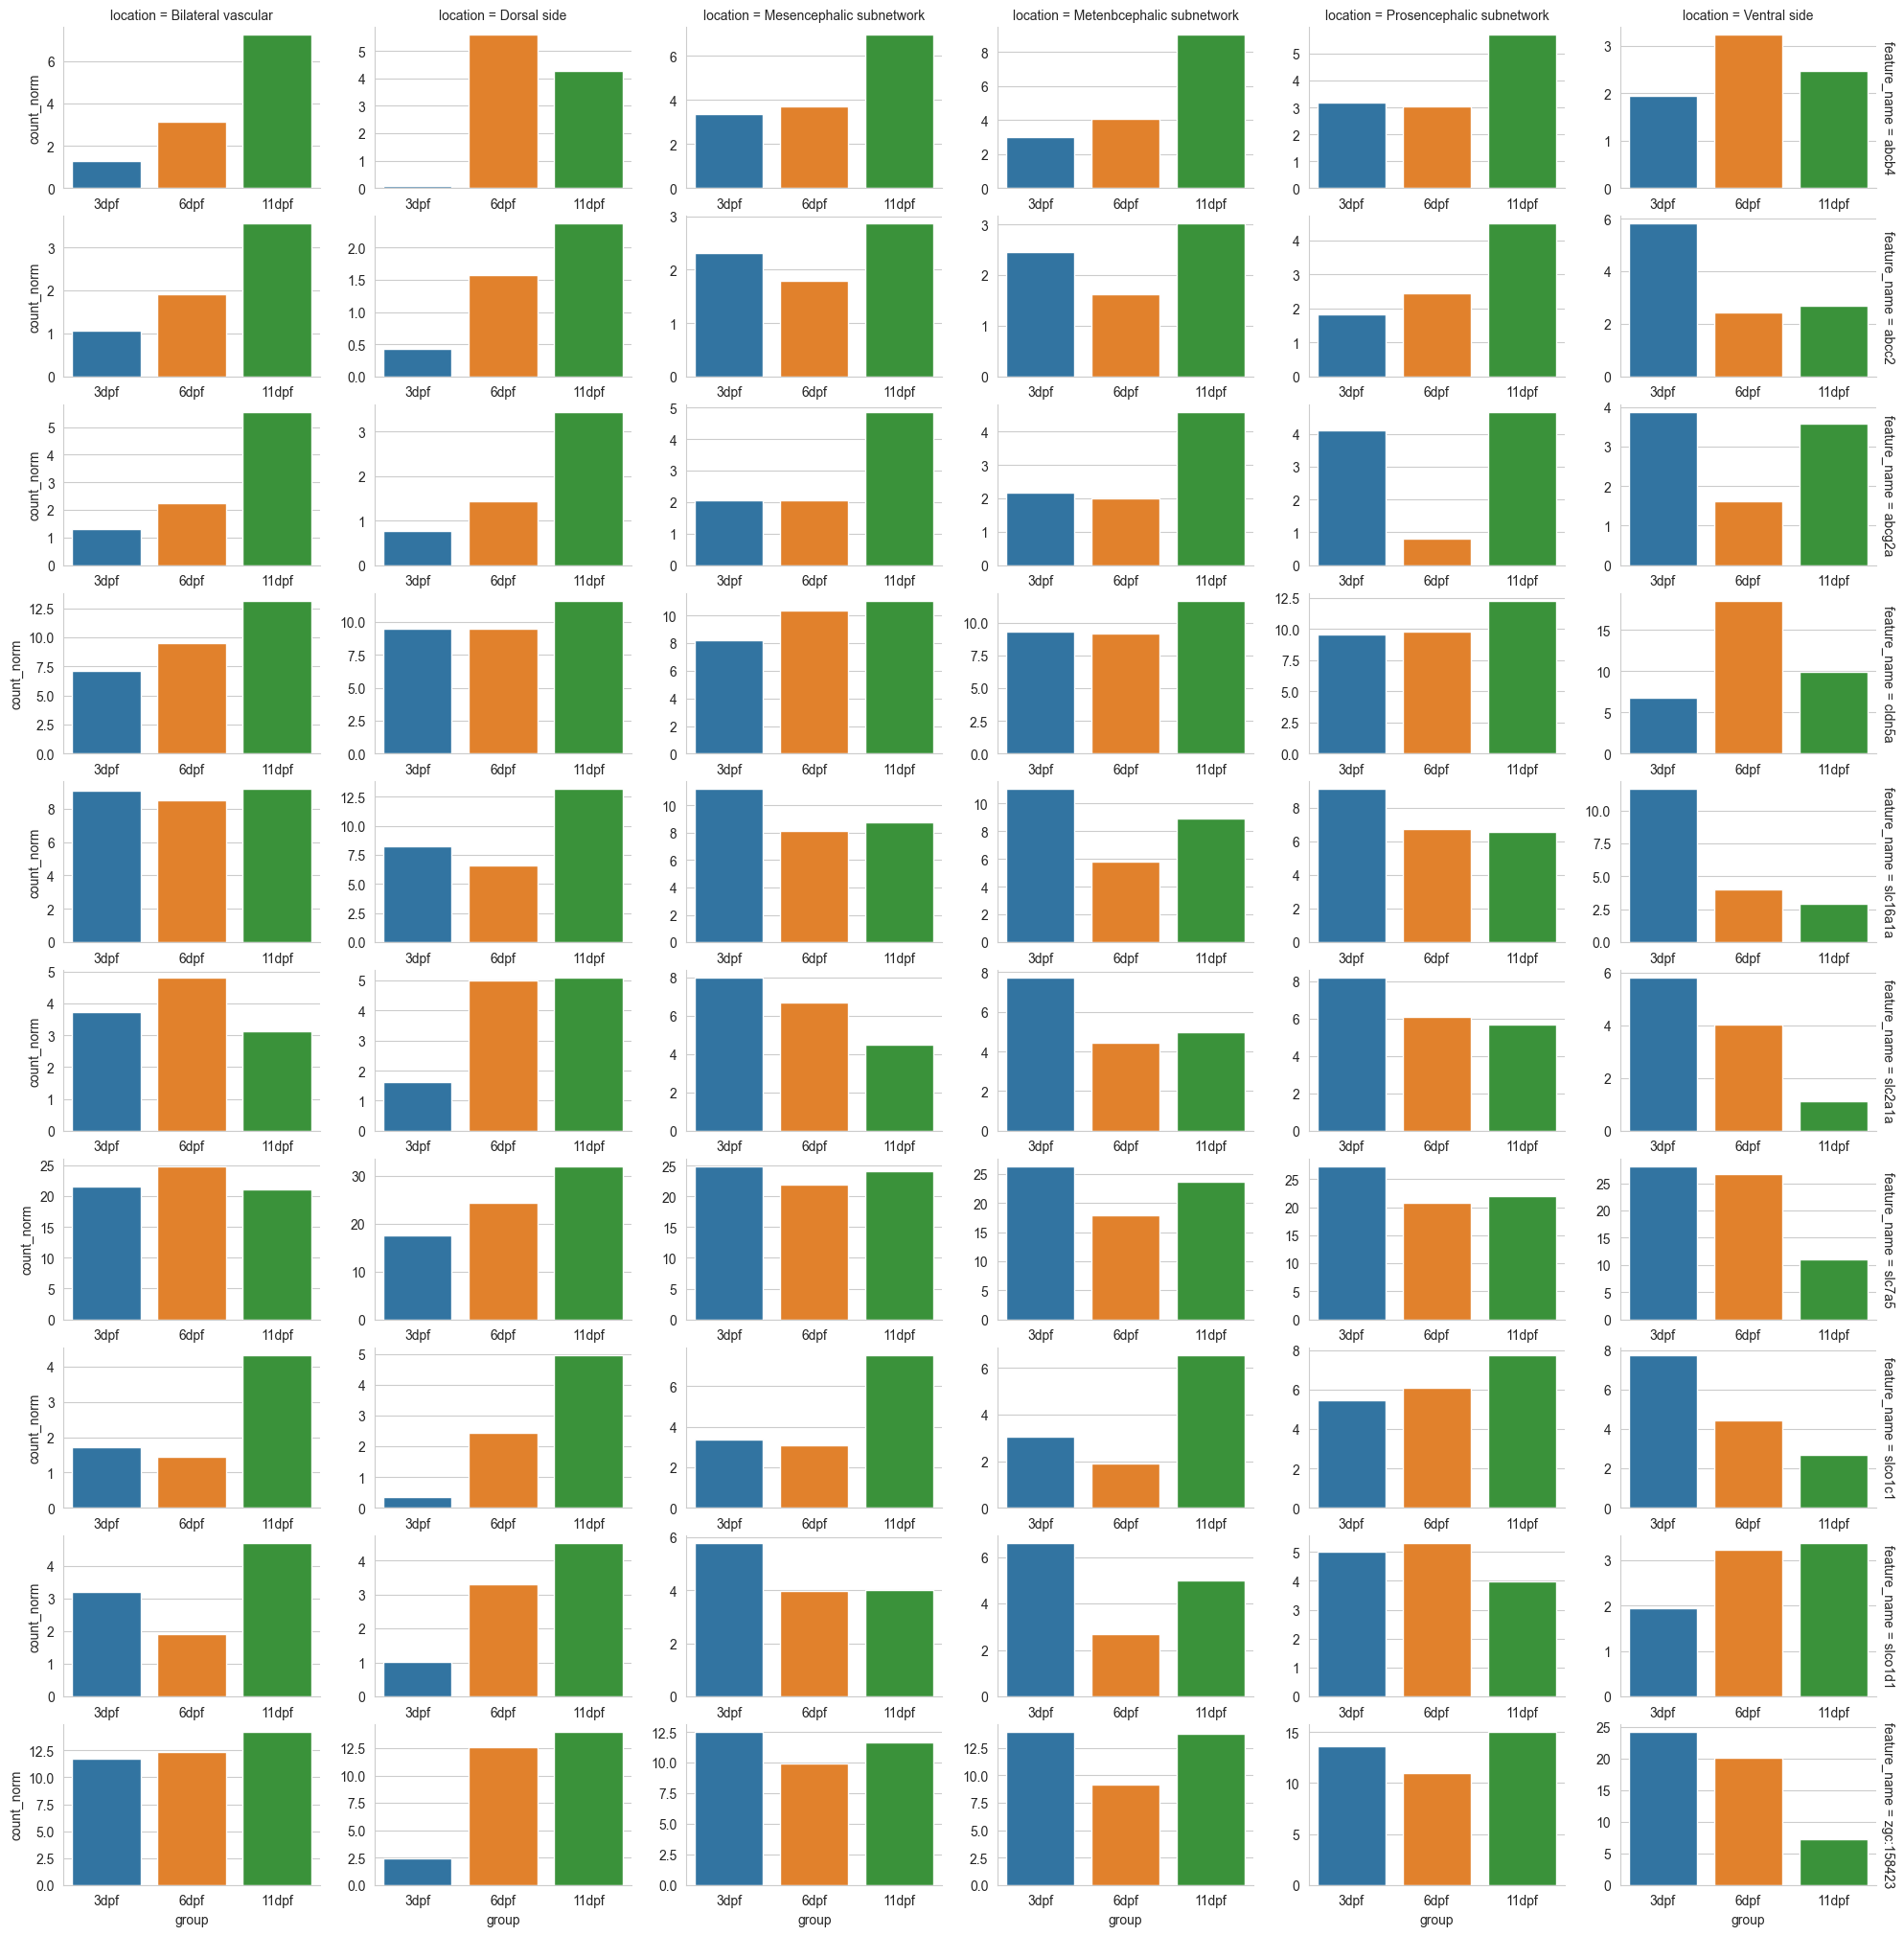

In [70]:
plot_data = vas_2[vas_2["feature_name"].isin(["slc16a1a", "zgc:158423", "slco1c1",'slc7a5',"slco1d1" ,"abcb4", "abcg2a", "abcc2",'slc2a1a',"cldn5a"])]
plot_data = plot_data.sort_values(by=["location", "feature_name"])
g = sns.FacetGrid(data=plot_data,row= "feature_name", col="location",margin_titles=True, hue = "group", sharey=False, sharex = False)
ax=g.map(sns.barplot, "group", "count_norm")
ax.figure.set_size_inches(20,20)

## 基于脑区统计细胞比例

In [1]:
import pandas as pd
import seaborn as sns

In [18]:
vas_local = pd.read_csv("./vascular_name_and_location.csv")
vas_local.columns = ["location", "region_name", "index"]
vas_local.head()

,location,region_name,index
0,Ventral side,CaDI,1
1,Ventral side,Willis,2
2,Prosencephalic subnetwork,PrCm,3
3,Mesencephalic subnetwork,AMsCtA,4
4,Mesencephalic subnetwork,MMsCtA,5


In [33]:
vas_cell_3dpf = pd.read_csv("./vas_cell_matrix_annotation_F314.csv", index_col = 0)
vas_cell_3dpf = vas_cell_3dpf[~vas_cell_3dpf["cell_type"].isin(["other", "UnEC"])]
vas_cell_3dpf["cell_type"] = vas_cell_3dpf["cell_type"].replace({"VEC_1":"VEC", "VEC_2":"VEC"})
vas_cell_3dpf.insert(0, "cell_id", vas_cell_3dpf.index)
vas_anno_3dpf = pd.read_csv("./region_annotation_with_feature_F314.csv", index_col = 0)
vas_anno_3dpf = vas_anno_3dpf.drop_duplicates(subset=["region_id"])
vas_anno_3dpf = vas_anno_3dpf[vas_anno_3dpf["region_id"].isin(vas_cell_3dpf["blood"])]
vas_anno_3dpf.insert(0, 'blood', vas_anno_3dpf.region_id)
vas_cell_3dpf = pd.merge(vas_cell_3dpf,vas_anno_3dpf,on = "blood")
vas_cell_3dpf = pd.merge(vas_cell_3dpf, vas_local, on = "region_name")
vas_cell_3dpf.head()

,cell_id,abcb4,abcc2,abcg2a,adgrl1a,agtr1b,aoc2,aplnrb,bcl6b,cldn5a,...,y,x,blood,cell_type,cor,region_id,region_name,feature_name,location,index
0,cell_1053,0,0,0,0,0,0,0,0,0,...,1870,15776,blood_76,CapEC,0.006,blood_76,PrV,slc7a5,Dorsal side,12
1,cell_2388,0,0,0,0,0,0,0,0,0,...,2010,15760,blood_76,CapEC,0.006,blood_76,PrV,slc7a5,Dorsal side,12
2,cell_3099,0,0,0,0,0,0,0,0,0,...,2079,15762,blood_79,VEC,0.437,blood_79,PrV,stab1,Dorsal side,12
3,cell_12069,0,0,0,0,0,0,0,0,0,...,7753,6758,blood_225,CapEC,0.202,blood_225,PMBC,spock3,Peripheral vessels,15
4,cell_12195,0,0,0,0,0,0,0,0,0,...,7827,7184,blood_236,VEC,0.283,blood_236,MtA,slc7a5,Metenbcephalic subnetwork,7


In [73]:
vas_cell_3dpf.shape

(3484, 49)

In [62]:
cell_in_vas = vas_cell_3dpf.groupby(["location"], as_index = False)["cell_type"].value_counts(normalize = True)
cell_in_vas["proportion"] = cell_in_vas["proportion"] * 100
cell_in_vas.head()

,location,cell_type,proportion
0,Dorsal side,CapEC,60.165975
1,Dorsal side,VEC,28.630705
2,Dorsal side,AEC,8.298755
3,Dorsal side,AngEC,2.904564
4,Mesencephalic subnetwork,CapEC,58.437500


/tmp/ipykernel_2138486/2021368612.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'Dorsal side'),
 Text(1, 0, 'Mesencephalic subnetwork'),
 Text(2, 0, 'Metenbcephalic subnetwork'),
 Text(3, 0, 'Peripheral vessels'),
 Text(4, 0, 'Prosencephalic subnetwork'),
 Text(5, 0, 'Ventral side')]

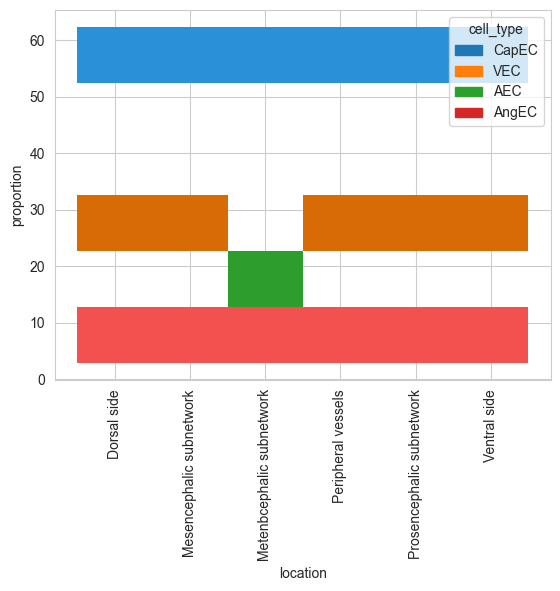

In [72]:
ax = sns.histplot(data=cell_in_vas, x="location", y="proportion", hue="cell_type",multiple="stack")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [70]:
cell_in_vas.groupby(["location"], as_index = False)["proportion"].sum().head()

,location,proportion
0,Dorsal side,100.0
1,Mesencephalic subnetwork,100.0
2,Metenbcephalic subnetwork,100.0
3,Peripheral vessels,100.0
4,Prosencephalic subnetwork,100.0


## 不同细胞类型在全血管上的定位


In [21]:
import pandas as pd
import numpy as np
import json
import glob
import cv2
import os
from matplotlib import pyplot as plt

### 3dpf


In [35]:
vas_anno_3dpf = pd.read_csv("./region_annotation_with_feature_F314.csv", index_col = 0)
vas_anno_3dpf = vas_anno_3dpf[~vas_anno_3dpf["region_name"].isin(['?','no','other', 'EYE',np.nan,'bottom','Trunk'])]
vas_anno_3dpf.replace({"region_name":{"dorsal": "Dorsal", "willis": 'Willis'}}, inplace = True)
vas_anno_3dpf.region_name.unique()

array(['Dorsal', 'PrV', 'CeCtA', 'MMsCtA', 'PHBC', 'MoCtA', 'MtA', 'PMBC',
       'PMsCtA', 'BA', 'PrA', 'NV', 'AMsCtA', 'Willis', 'PrCm', 'CaDI'],
      dtype=object)

In [41]:
cell_anno_3dpf = pd.read_csv("./vas_cell_matrix_annotation_F314.csv", index_col = 0)
cell_anno_3dpf.insert(0, "cell_id", cell_anno_3dpf.index)
print(cell_anno_3dpf.shape)
cell_anno_3dpf = cell_anno_3dpf[~cell_anno_3dpf["cell_type"].isin(["other", "UnEC"])]
cell_anno_3dpf = cell_anno_3dpf[cell_anno_3dpf["cor"] >=0.25]
cell_anno_3dpf = cell_anno_3dpf.loc[:,["cell_id", "x", "y", "cell_type", "blood"]]
cell_anno_3dpf.replace({"cell_type": {"VEC_1": "VEC", "VEC_2": "VEC"}}, inplace = True)
cell_anno_3dpf = cell_anno_3dpf[cell_anno_3dpf["blood"].isin(vas_anno_3dpf['region_id'])]
print(cell_anno_3dpf.shape)
cell_anno_3dpf.head()

(9766, 44)
(1667, 5)


,cell_id,x,y,cell_type,blood
cell_145,cell_145,16480,1713,CapEC,blood_73
cell_157,cell_157,16496,1712,CapEC,blood_73
cell_178,cell_178,16470,1726,AEC,blood_73
cell_224,cell_224,16438,1738,VEC,blood_73
cell_237,cell_237,16801,1746,AEC,blood_75


In [42]:
egfp_order = glob.glob("./F314-1230/output/egfp_order/*.tif")
egfp_order.sort()
egfp_order

['./F314-1230/output/egfp_order/01-02716-07658.tif',
 './F314-1230/output/egfp_order/02-02124-16834.tif',
 './F314-1230/output/egfp_order/03-01170-25864.tif',
 './F314-1230/output/egfp_order/04-01130-34792.tif',
 './F314-1230/output/egfp_order/05-08262-07600.tif',
 './F314-1230/output/egfp_order/06-08540-16156.tif',
 './F314-1230/output/egfp_order/07-07692-25172.tif',
 './F314-1230/output/egfp_order/08-06236-36068.tif',
 './F314-1230/output/egfp_order/09-14558-06494.tif',
 './F314-1230/output/egfp_order/10-14838-16166.tif',
 './F314-1230/output/egfp_order/11-13978-27278.tif',
 './F314-1230/output/egfp_order/12-13930-35606.tif',
 './F314-1230/output/egfp_order/13-21130-07918.tif',
 './F314-1230/output/egfp_order/14-20750-15818.tif',
 './F314-1230/output/egfp_order/15-20238-25914.tif',
 './F314-1230/output/egfp_order/16-20006-34970.tif',
 './F314-1230/output/egfp_order/17-26878-05578.tif',
 './F314-1230/output/egfp_order/18-26714-15262.tif',
 './F314-1230/output/egfp_order/19-26774-25318

In [51]:
data = cell_anno_3dpf
if not os.path.exists("./cell_distr_F314"):
    os.mkdir("./cell_distr_F314")
for i in range(28):
    # ax = axs[i]
    egfp_order_n = egfp_order[i]
    roi = np.int_(egfp_order_n[-18:-4].split("-")[1:])[::-1]
    width, height = 3500, 2200
    start_x, start_y, end_x, end_y = roi[0] - width / 2, roi[1] - height / 2, roi[0] + width / 2, roi[1] + height / 2
    egfp_image = cv2.imread(egfp_order_n, cv2.IMREAD_GRAYSCALE)
    plt.imshow(egfp_image * 2.3, cmap="gray")
    slice = data[(data.x >= start_x) & (data.x <= end_x) & (data.y > start_y) & (data.y < end_y)]
    colors = {"AEC":"#e7ba90", "AngEC":"#90e7ba",'CapEC':"#ba90e7",'VEC':"#90bae7"}
    cell_type = ['VEC']
    for c in cell_type:
        plot_data = slice[slice["cell_type"] == c]
        plt.scatter(plot_data.x - start_x, plot_data.y - start_y, s=3, label=c, color=colors[c], linewidths=0)
        plt.axis("off")
    # ax.legend(['AEC', 'AngEC', 'CapEC', 'VEC'], fontsize=60)
    plt.tight_layout()
    plt.axis('off')
    plt.savefig("./cell_distr_F314/VEC_{}.tif".format(egfp_order_n[-18:-4]), bbox_inches='tight', pad_inches=0, dpi=500)
    plt.close()
    print("{}.tif done!".format(egfp_order_n[-18:-4]))


01-02716-07658.tif done!
02-02124-16834.tif done!
03-01170-25864.tif done!
04-01130-34792.tif done!
05-08262-07600.tif done!
06-08540-16156.tif done!
07-07692-25172.tif done!
08-06236-36068.tif done!
09-14558-06494.tif done!
10-14838-16166.tif done!
11-13978-27278.tif done!
12-13930-35606.tif done!
13-21130-07918.tif done!
14-20750-15818.tif done!
15-20238-25914.tif done!
16-20006-34970.tif done!
17-26878-05578.tif done!
18-26714-15262.tif done!
19-26774-25318.tif done!
20-26978-35230.tif done!
21-33338-04378.tif done!
22-35090-14314.tif done!
23-35356-26176.tif done!
24-35252-36148.tif done!
25-41116-02236.tif done!
26-41020-12452.tif done!
27-41668-24924.tif done!
28-42604-34788.tif done!


### 6dpf

In [56]:
vas_anno_6dpf = pd.read_csv("./region_annotation_with_feature_F610.csv", index_col = 0)
vas_anno_6dpf.replace({"region_name": {"PrCmS": "PrCm",'DorsalS': "Dorsal","MMoCtA":"MoCtA"}}, inplace = True)
print(vas_anno_6dpf.region_name.unique())
vas_anno_6dpf = vas_anno_6dpf[~vas_anno_6dpf["region_name"].isin(['?','no','Other', 'EYE',np.nan,'bottom','Trunk'])]

vas_anno_6dpf.region_name.unique()

['MoCtA' 'AMsCtA' 'PMsCtA' 'PrCm' 'CeCtA' 'Other' 'PrA' 'BA' 'PHBC' 'PrV'
 'Dorsal' 'MMsCtA' 'MtA' 'PMBC' 'Willis' 'NV' 'Trunk' nan 'CaDI']


array(['MoCtA', 'AMsCtA', 'PMsCtA', 'PrCm', 'CeCtA', 'PrA', 'BA', 'PHBC',
       'PrV', 'Dorsal', 'MMsCtA', 'MtA', 'PMBC', 'Willis', 'NV', 'CaDI'],
      dtype=object)